## Introdução ao Problema e contextualização

**DESAFIO: Classificação de Renda — Dataset: Adult (Census Income)** <br>
Descrição:
<br>
O conjunto de dados “Adult” (Census Income) reúne informações do censo dos EUA
de 1994, com 48.842 registros e 14 atributos demográficos e socioeconômicos. Seu
objetivo é construir um modelo de classificação binária para prever se a renda anual
de um indivíduo excede US$ 50.000.

## Objetivo

Prever se uma pessoa ganha mais de US$ 50 mil por ano, com base em dados socioeconômicos como idade, escolaridade, horas de trabalho, ocupação etc

## Tarefa principal:

    Treinar e comparar Árvore de Decisão e Random Forest

    Avaliar com:

        Acurácia

        Precisão

        Recall

        F1-score

        Matriz de confusão

        Gráfico de importância dos atributos

## Carregamento do arquivo e Análise de dados

In [ ]:
import pandas as pd

df = pd.read_csv('adult.csv')

# Visão geral dos dados
print("Primeiros dados do arquivo CSV")
print(df.head)
print("\n")

print("Analisando a forma do arquivo CSV")
print(df.shape)
print("\n")

print("Analisando informações de cada coluna (variável) do arquivo CSV")
print(df.info())
print("\n")

## NOTA : Embora nas informações diga que os valores não são nulos
## em algumas colunas os valores estão identificados como '?'
## O que indica que não foram coletados

print("Analisando dados estatísticos do arquivo CSV")
print(df.describe(include='all'))

Primeiros dados do arquivo CSV
<bound method NDFrame.head of        age workclass  fnlwgt     education  education.num      marital.status  \
0       90         ?   77053       HS-grad              9             Widowed   
1       82   Private  132870       HS-grad              9             Widowed   
2       66         ?  186061  Some-college             10             Widowed   
3       54   Private  140359       7th-8th              4            Divorced   
4       41   Private  264663  Some-college             10           Separated   
...    ...       ...     ...           ...            ...                 ...   
32556   22   Private  310152  Some-college             10       Never-married   
32557   27   Private  257302    Assoc-acdm             12  Married-civ-spouse   
32558   40   Private  154374       HS-grad              9  Married-civ-spouse   
32559   58   Private  151910       HS-grad              9             Widowed   
32560   22   Private  201490       HS-grad      

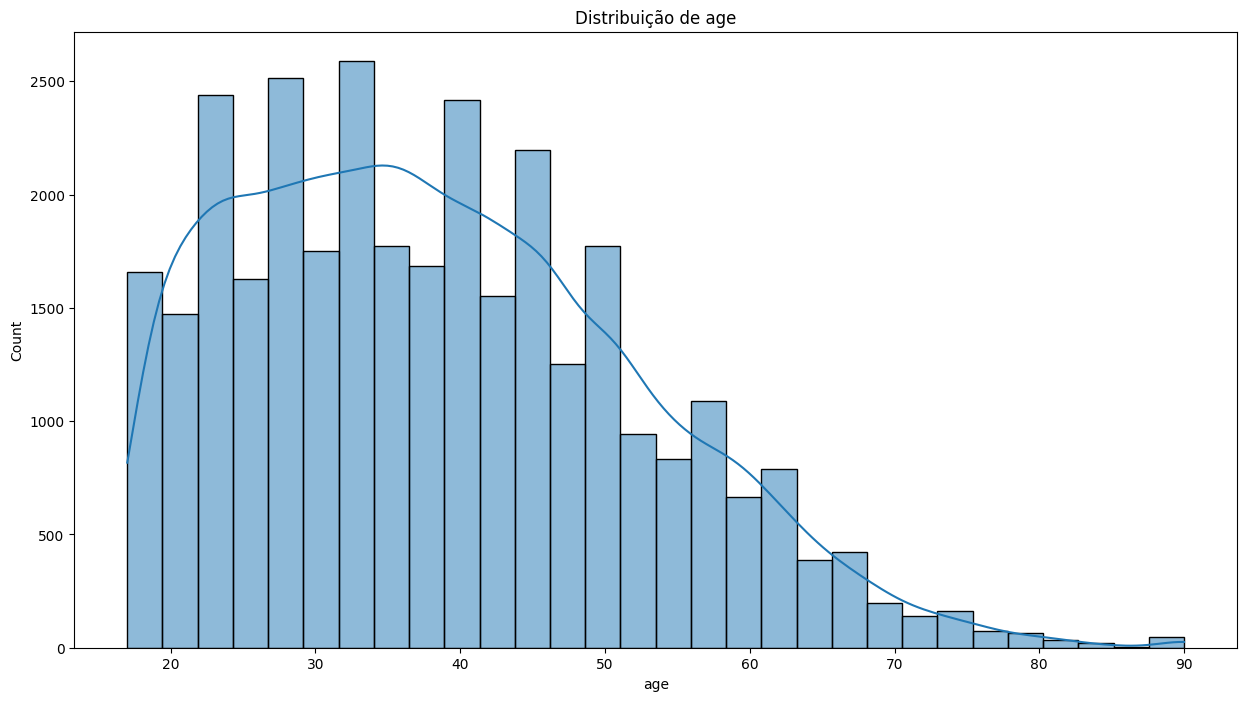

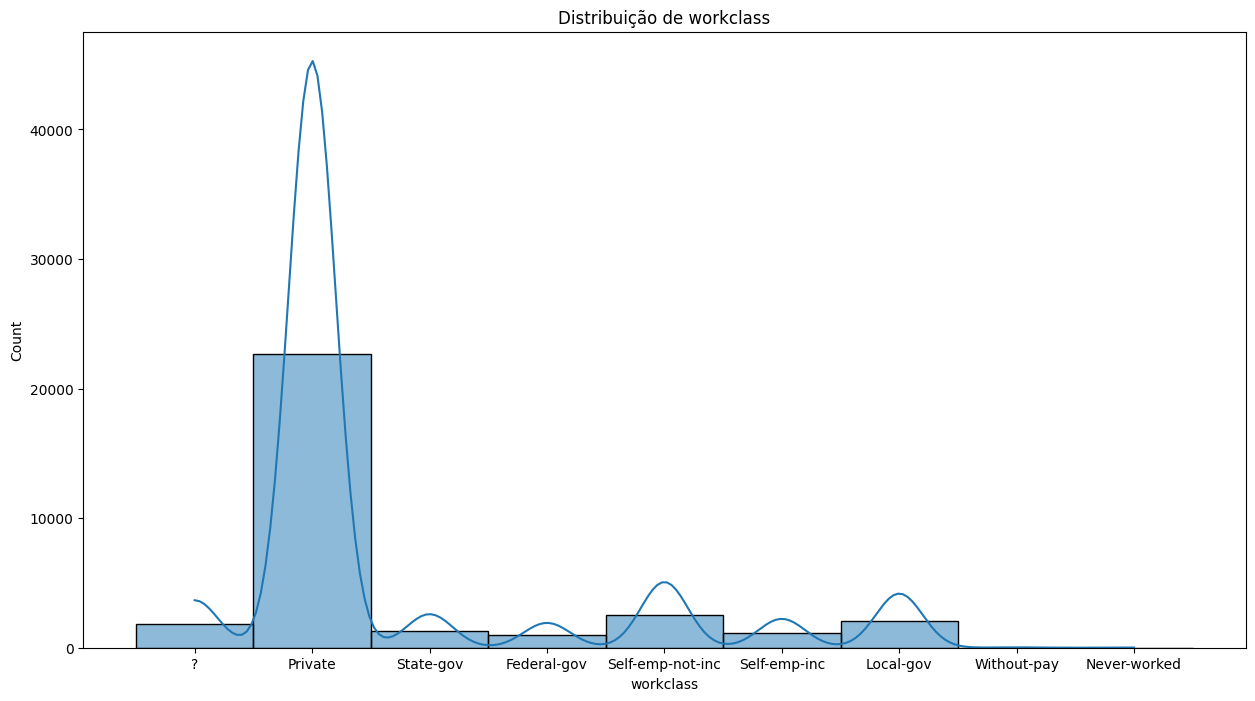

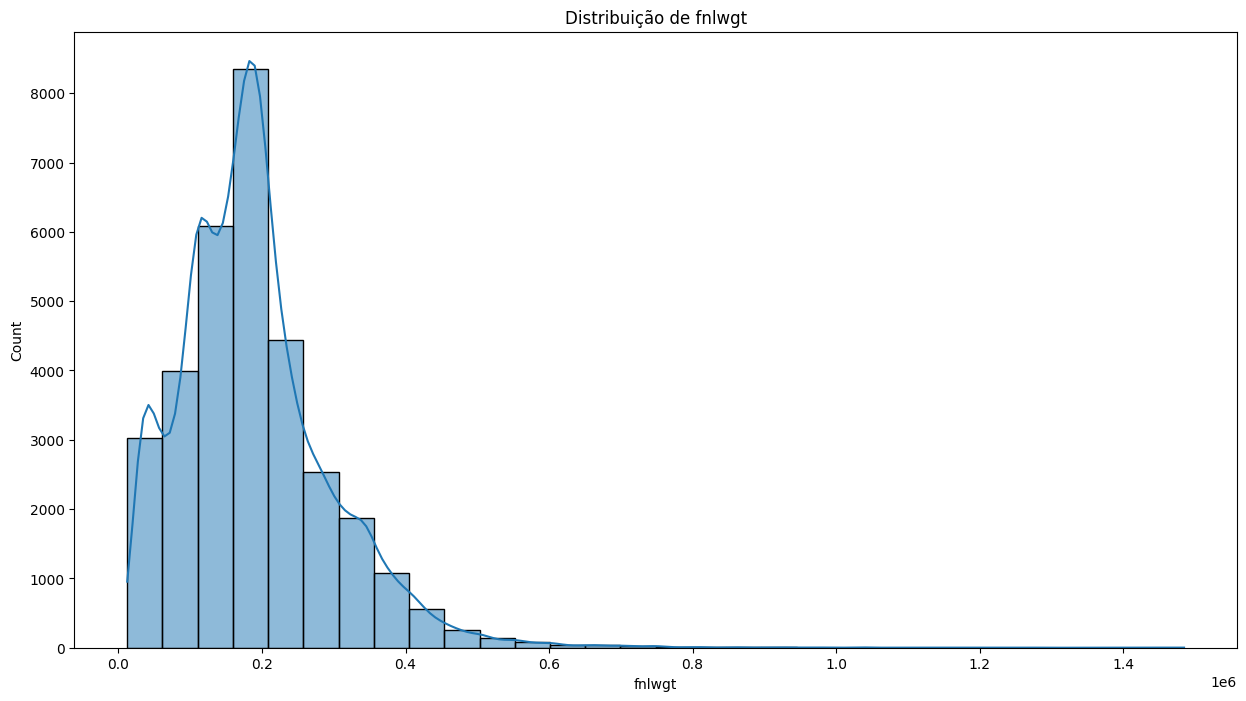

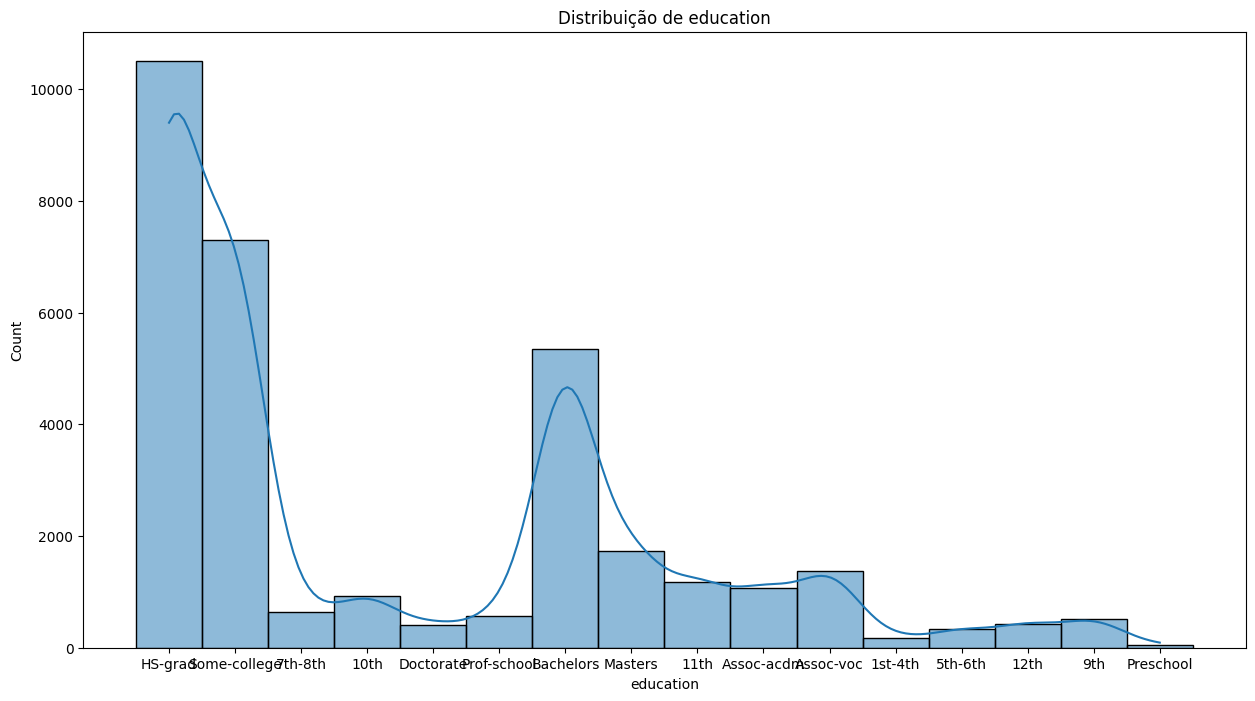

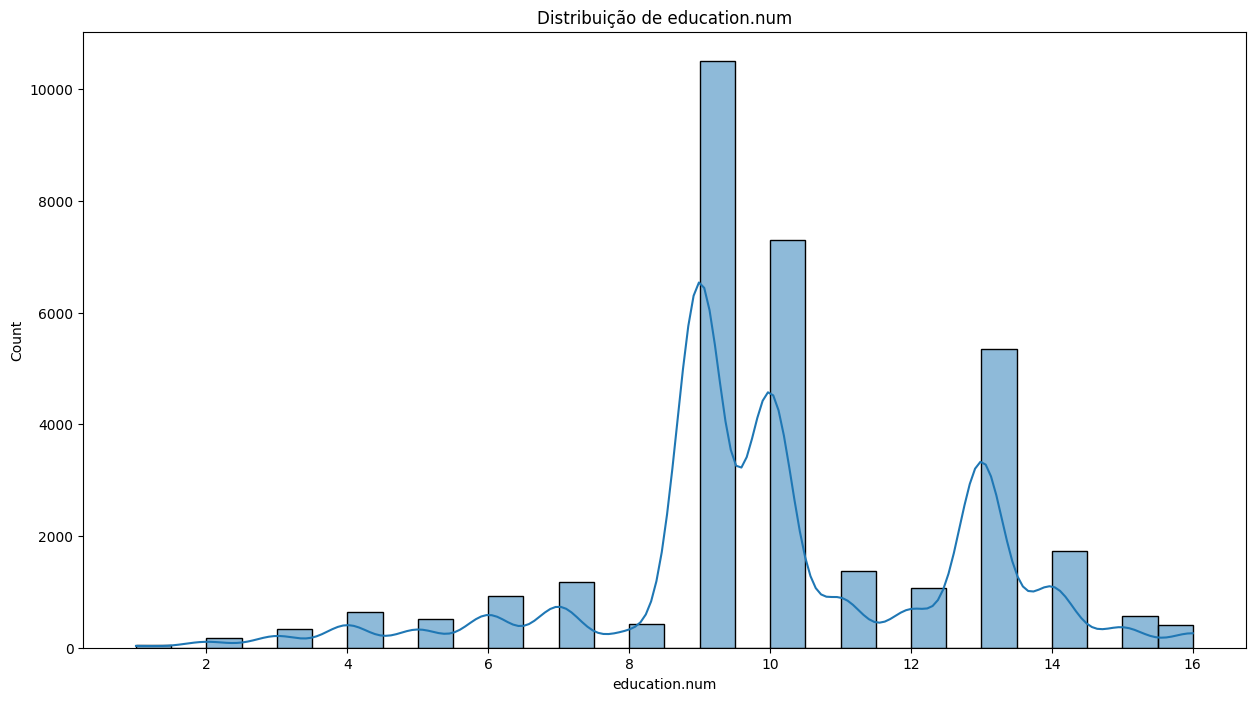

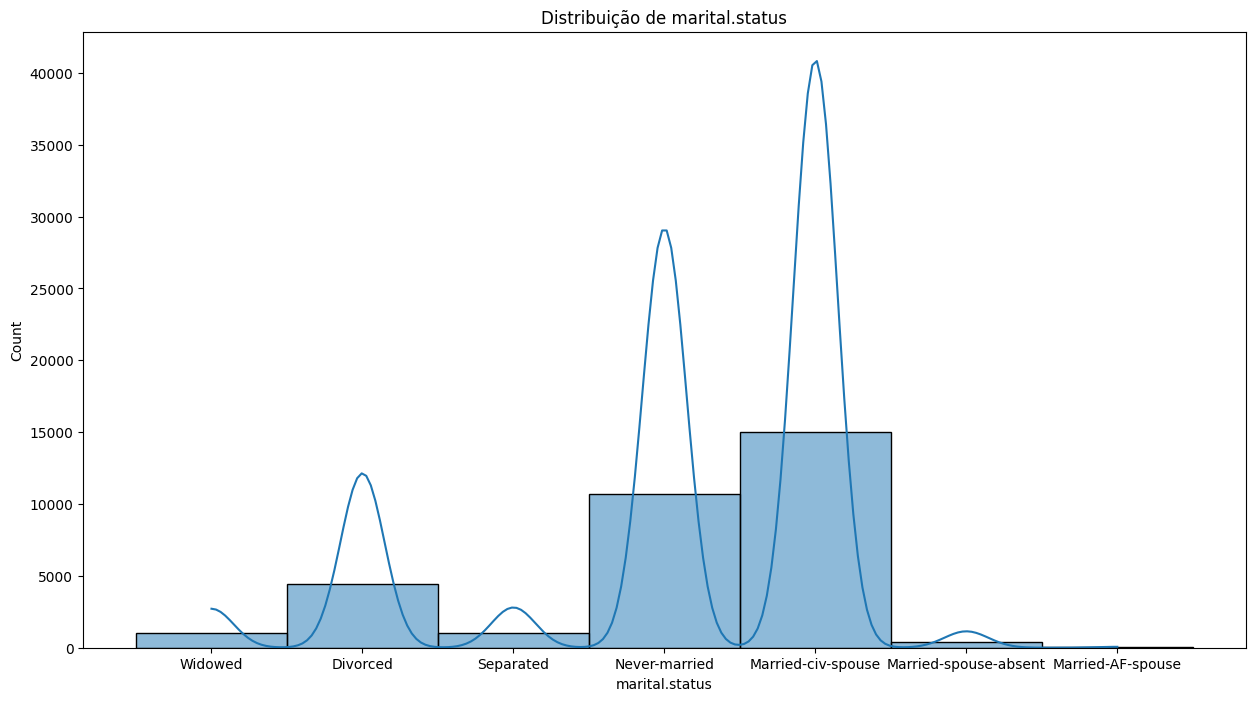

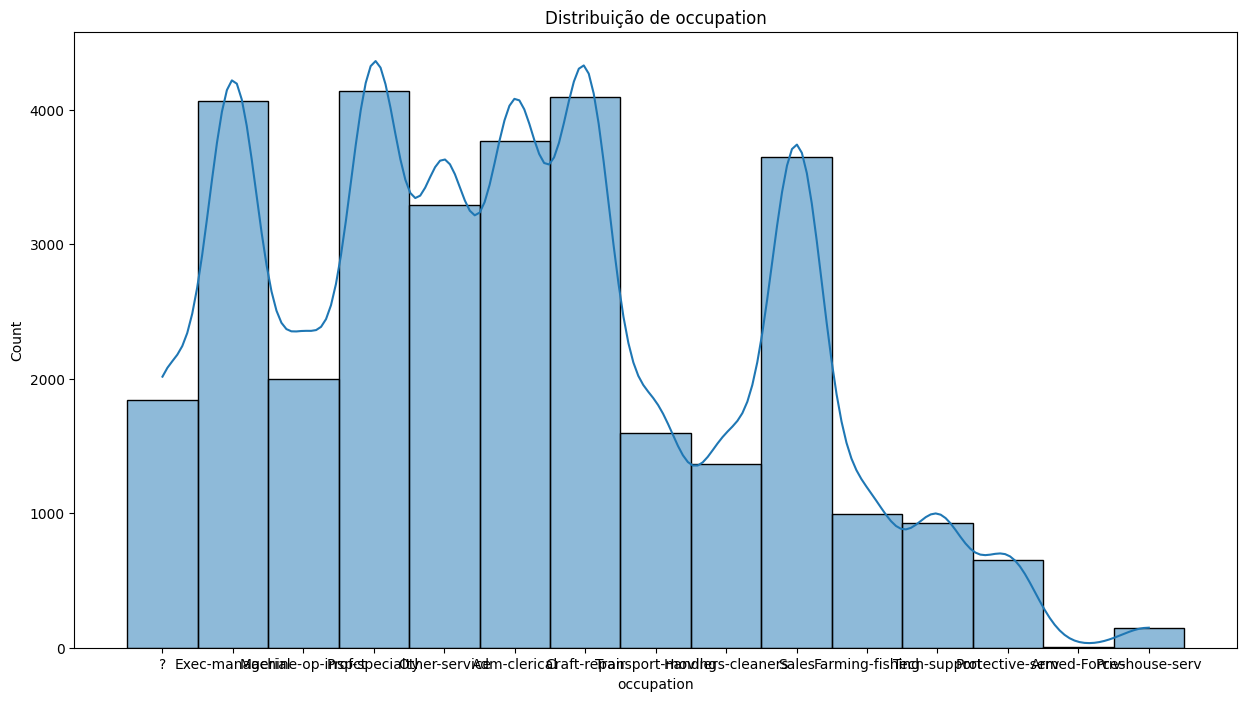

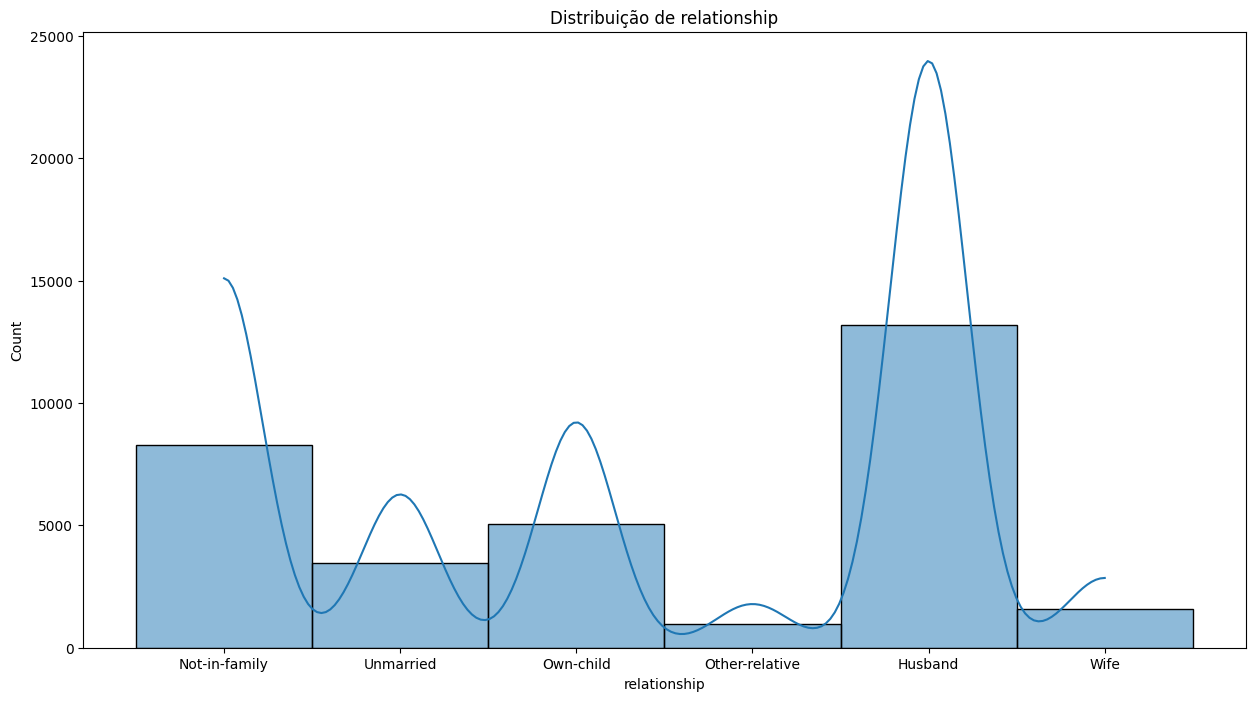

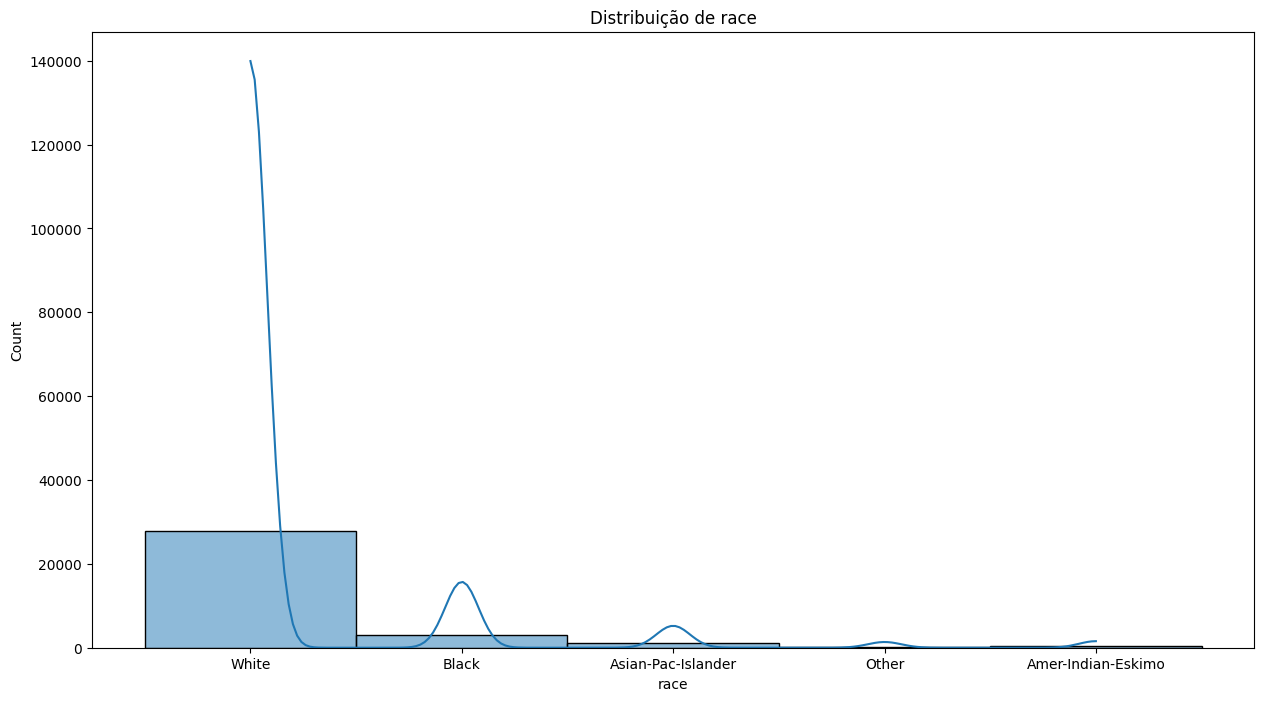

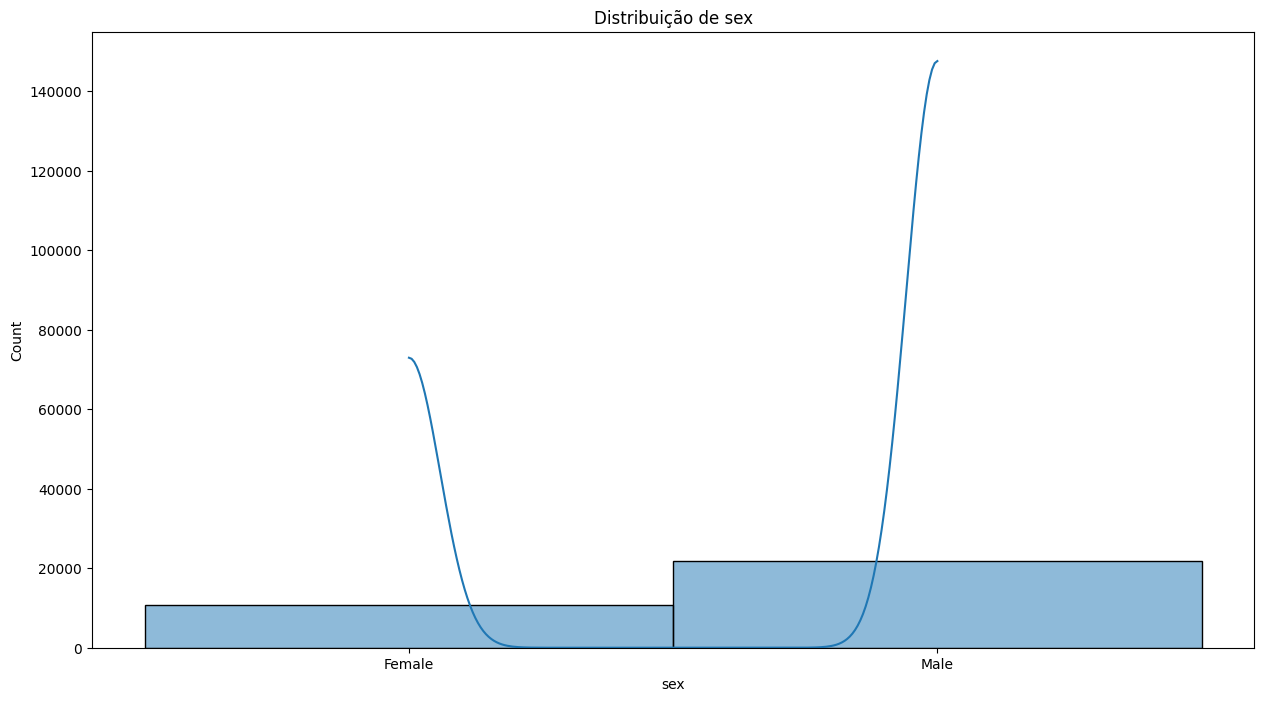

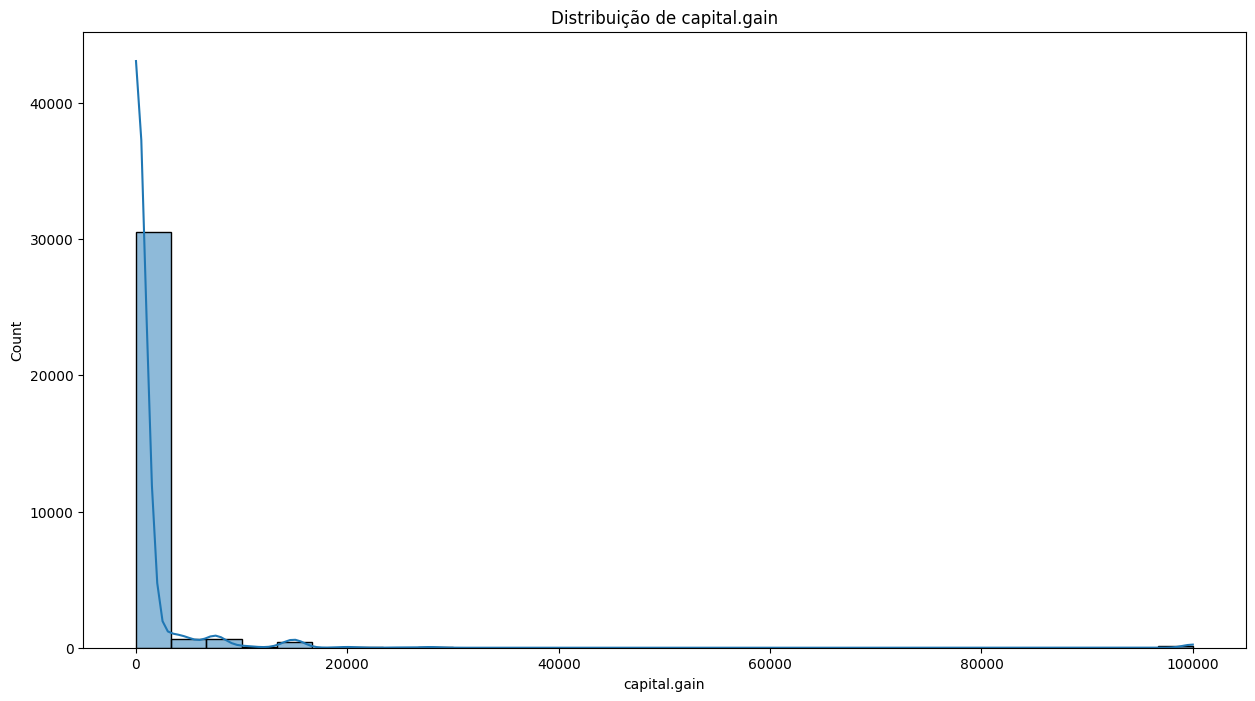

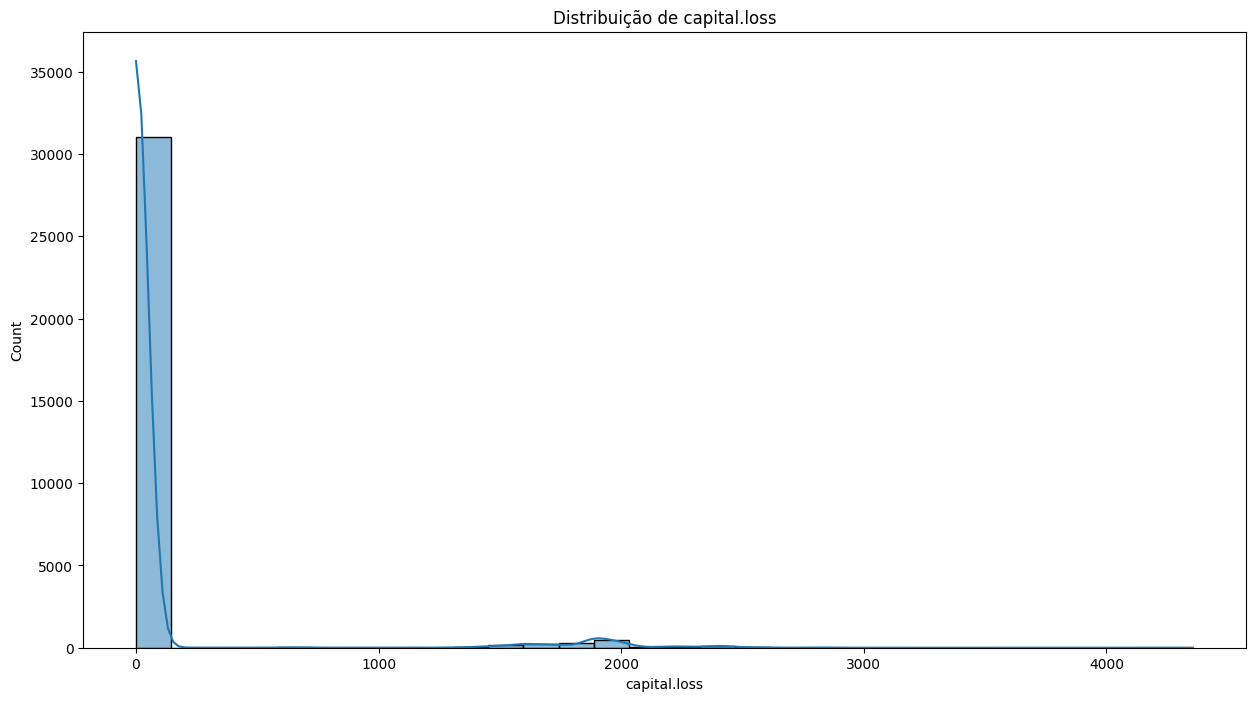

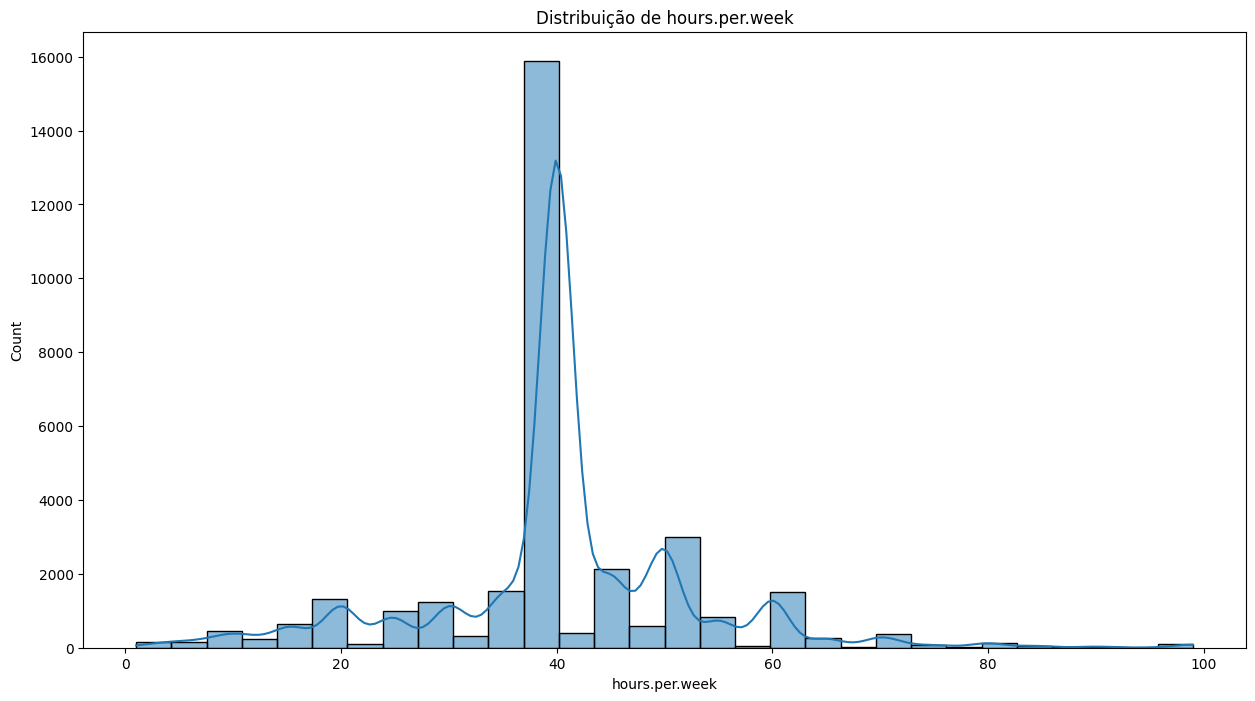

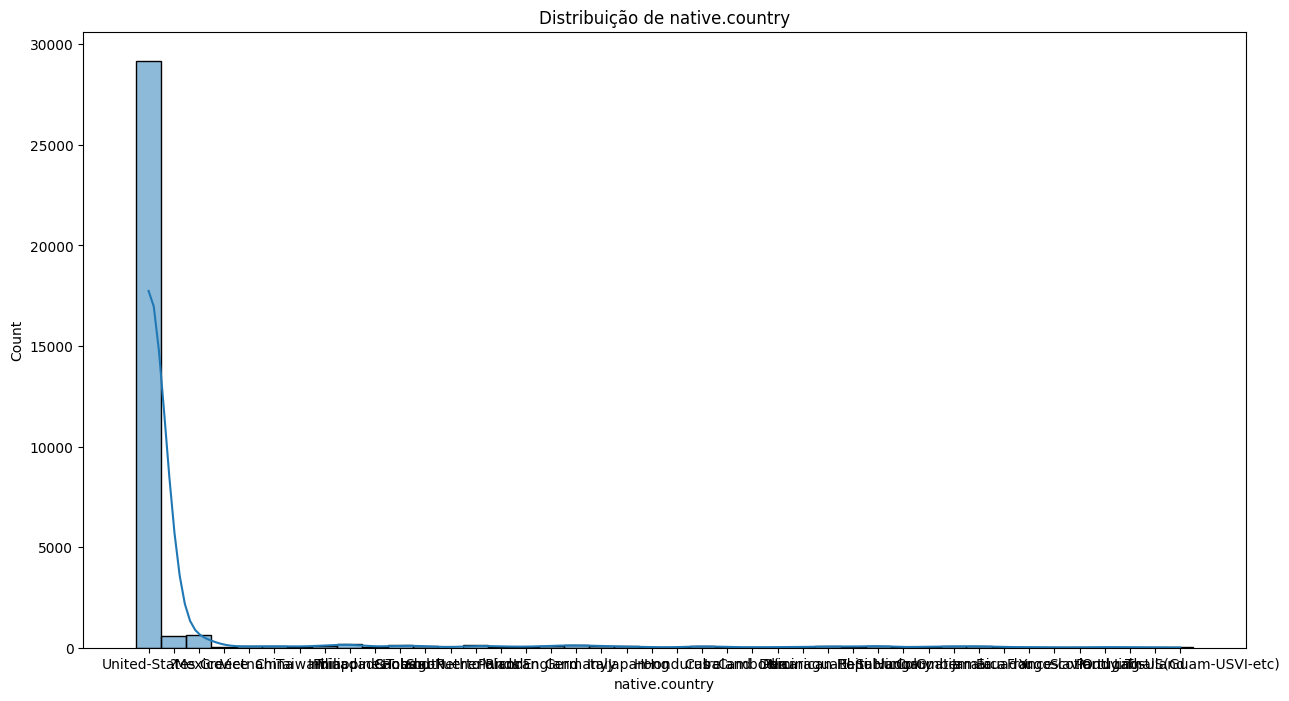

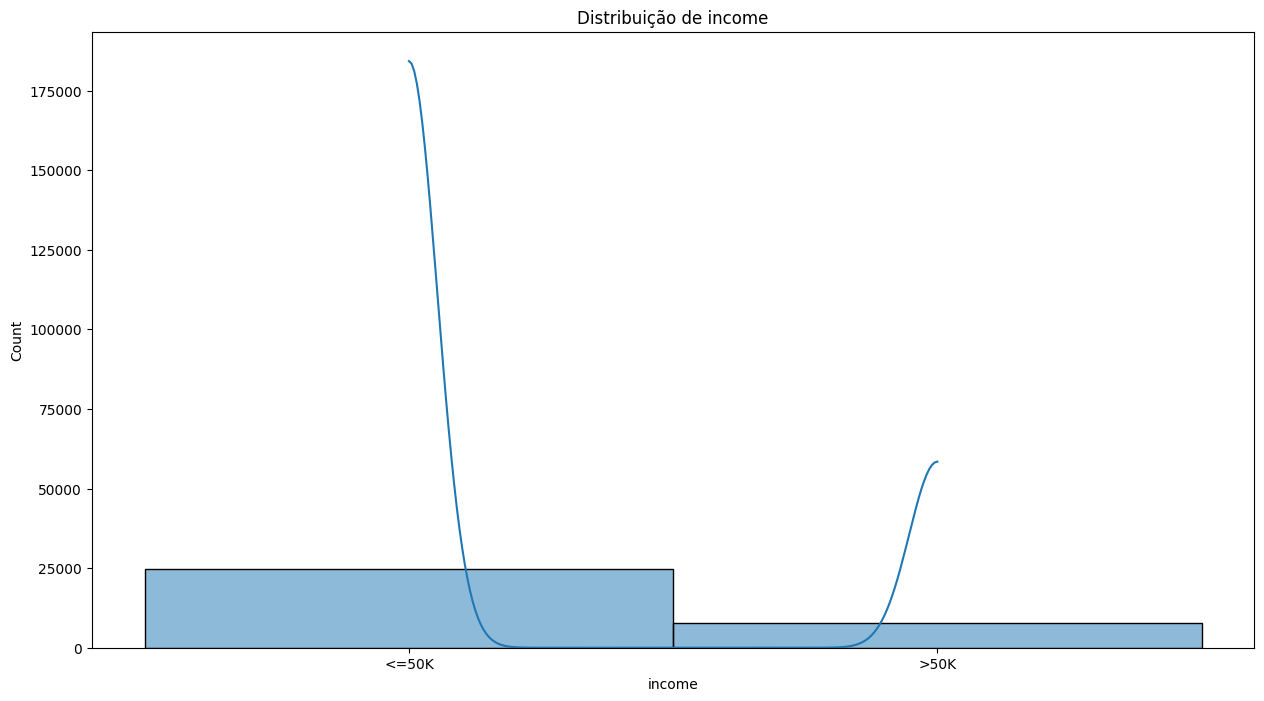

In [ ]:
## Analisando distribuição de cada feature (variável)
import matplotlib.pyplot as plt
import seaborn as sns

for col in df.columns:
  plt.figure(figsize=(15,8))
  sns.histplot(data=df, x=col, kde=True, bins=30)
  plt.title(f'Distribuição de {col}')
  plt.show()

## Possíveis interpretações gráficas

`age:` distribuição levemente à direita (mais adultos jovens)

`hours-per-week:` pico em 40h

`capital-gain e capital-loss:` altamente enviesados (muitos zeros)

`fnlwgt:` distribuição técnica — não representa "peso" intuitivo, mas é importante para inferência amostral (muito variável)

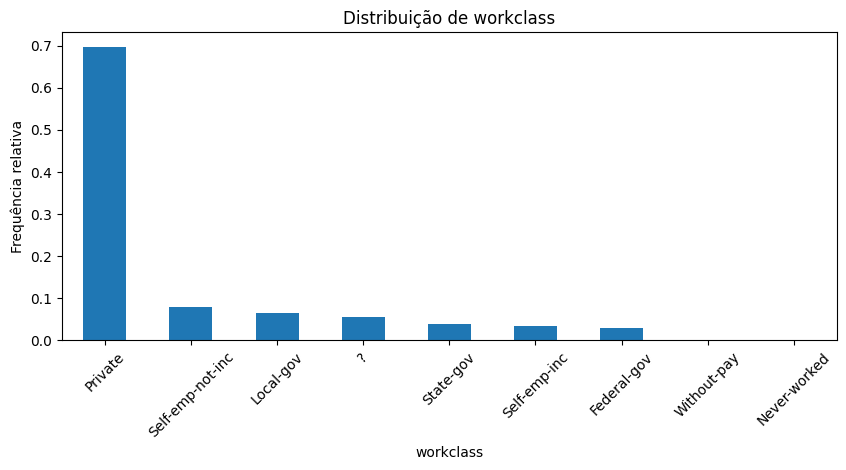

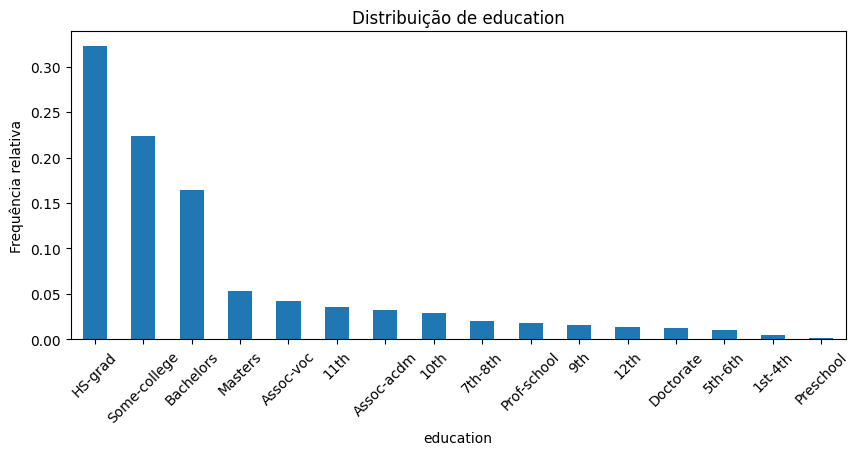

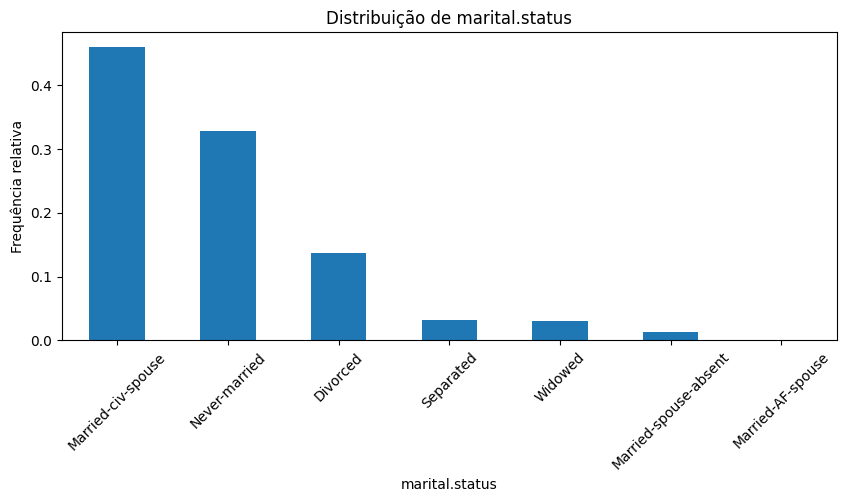

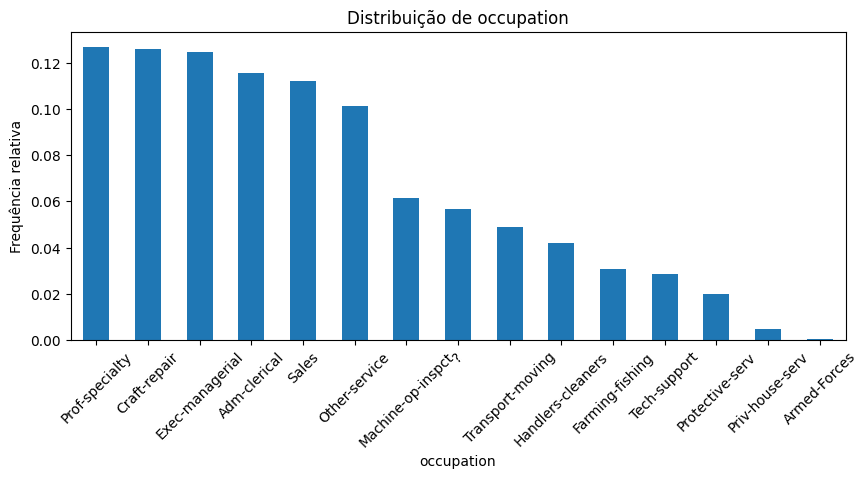

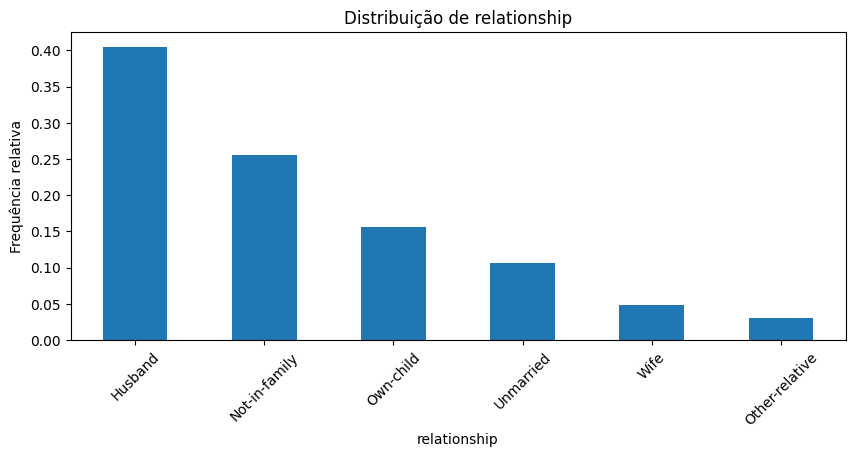

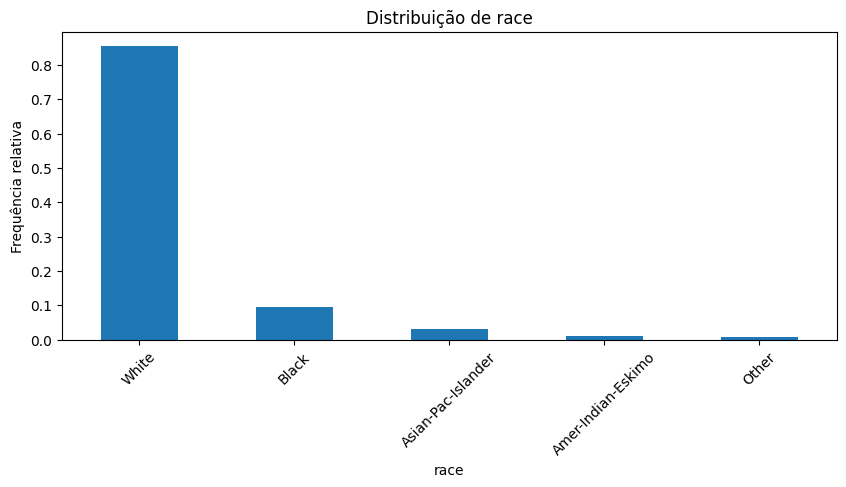

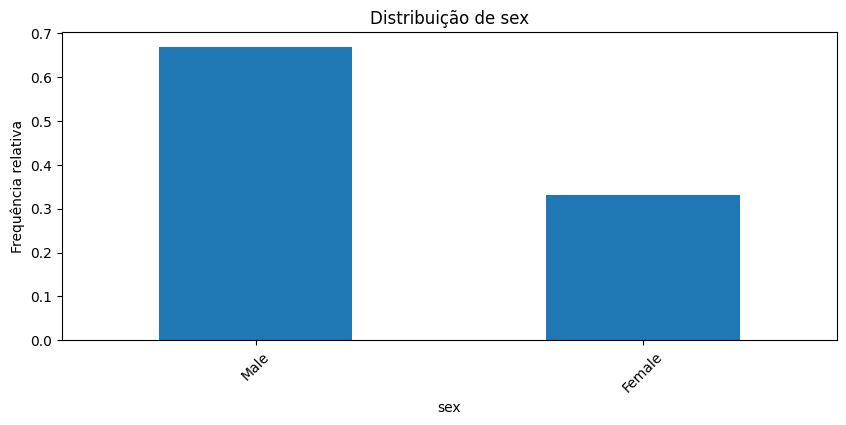

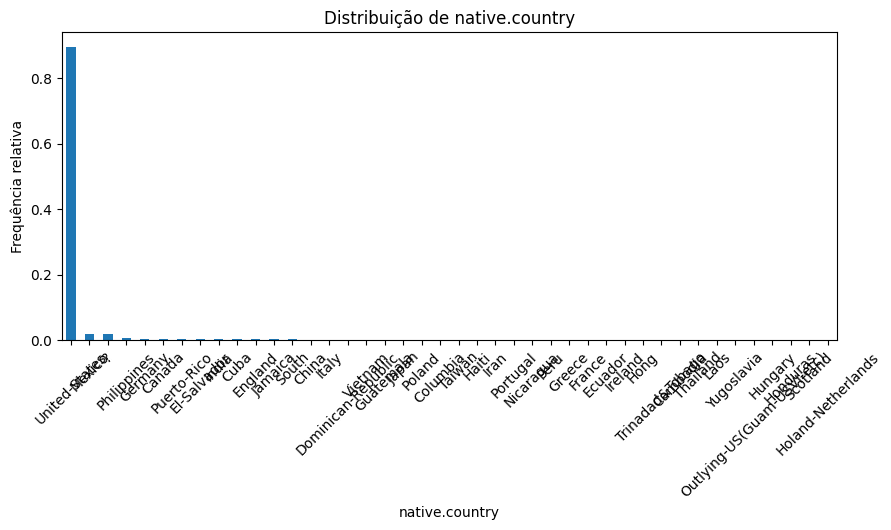

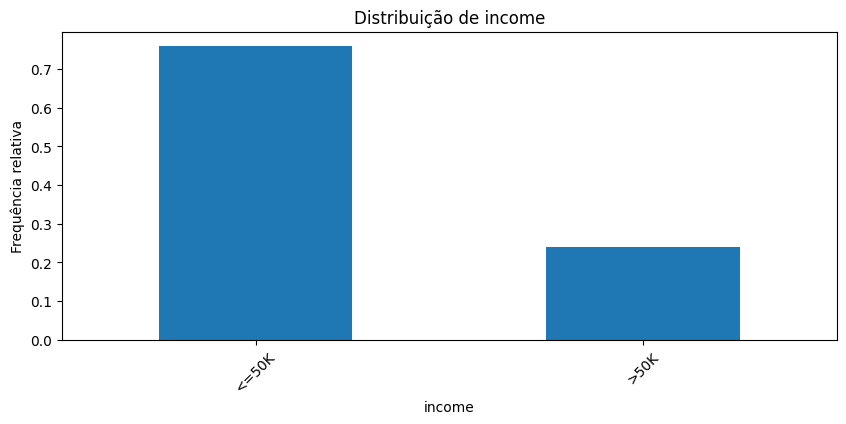

In [ ]:
## análise categórica
cat_cols = df.select_dtypes(include='object').columns

for col in cat_cols:
    plt.figure(figsize=(10,4))
    df[col].value_counts(normalize=True).plot(kind='bar')
    plt.title(f'Distribuição de {col}')
    plt.ylabel('Frequência relativa')
    plt.xticks(rotation=45)
    plt.show()


Percebemos que o paíse de origem dominate é os EUA, o que pode indicar a dominância de empregos privados sobre os outros. Vemos também que a coleta foi feita entre consideravelmente mais homens do que mulheres (brancos) e o grau de educação se concentra no ensino médio

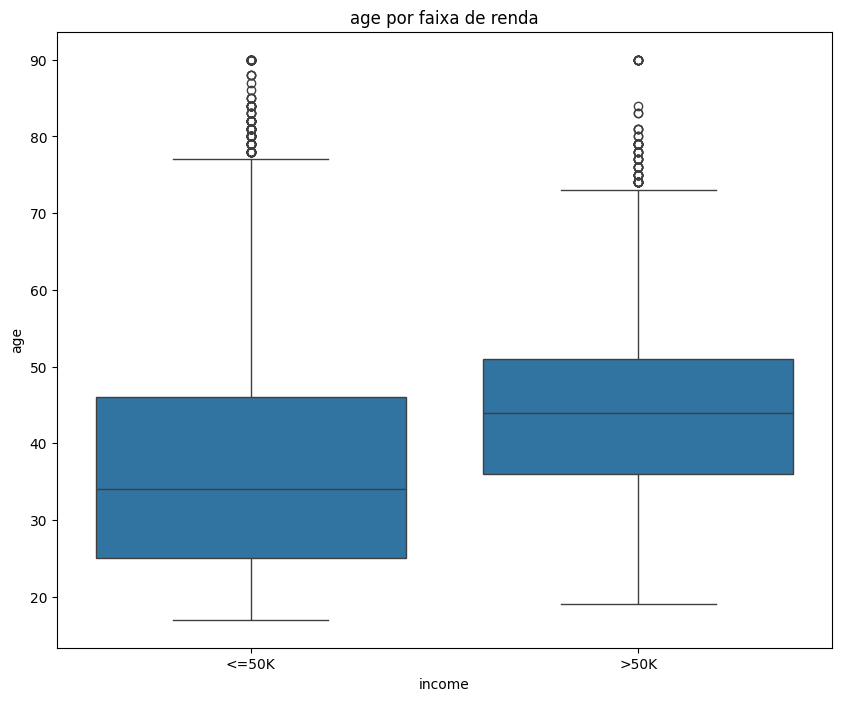

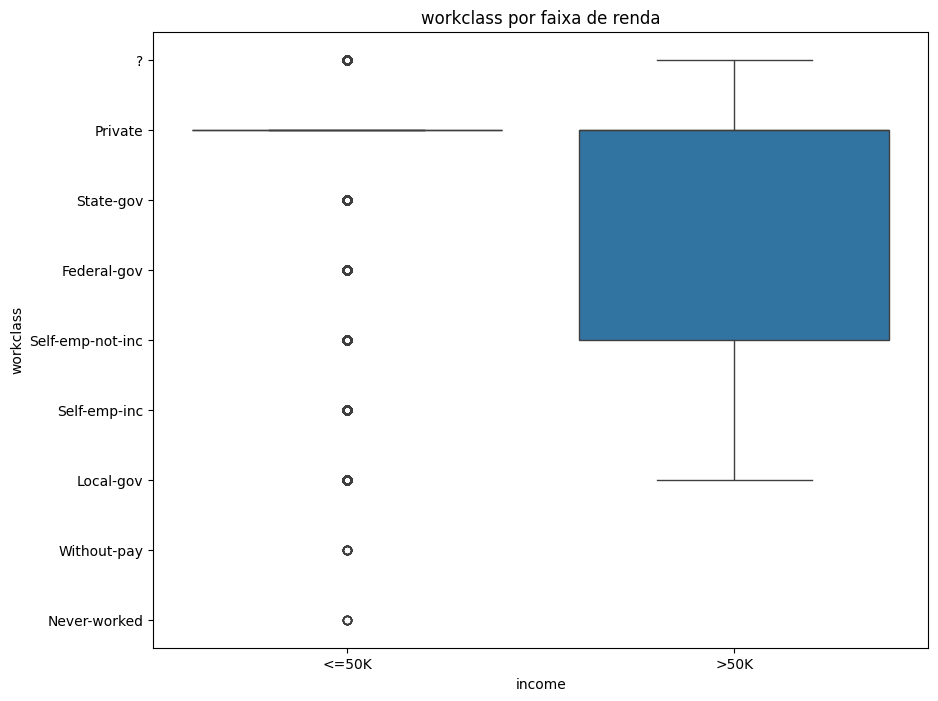

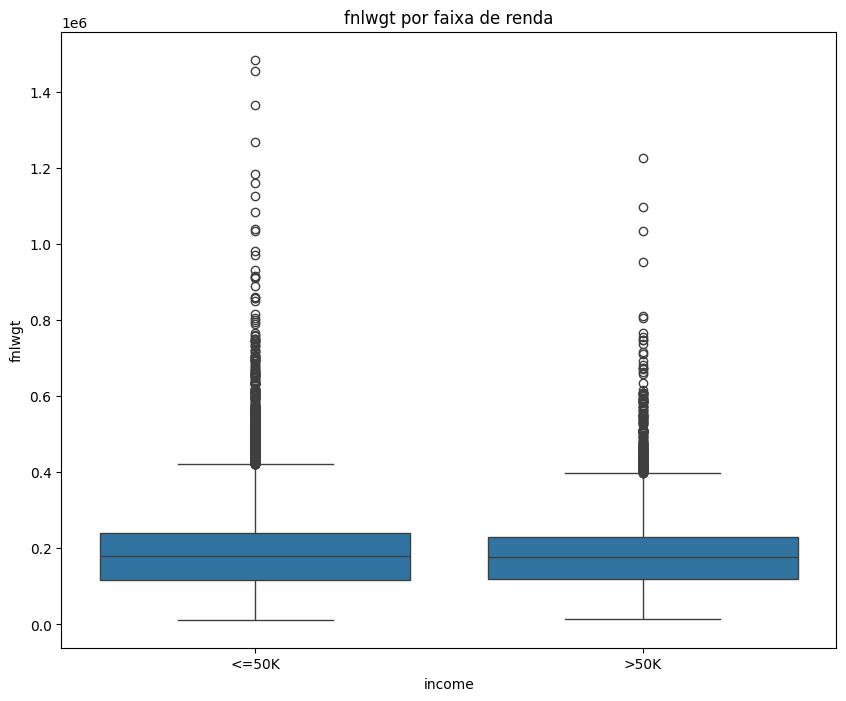

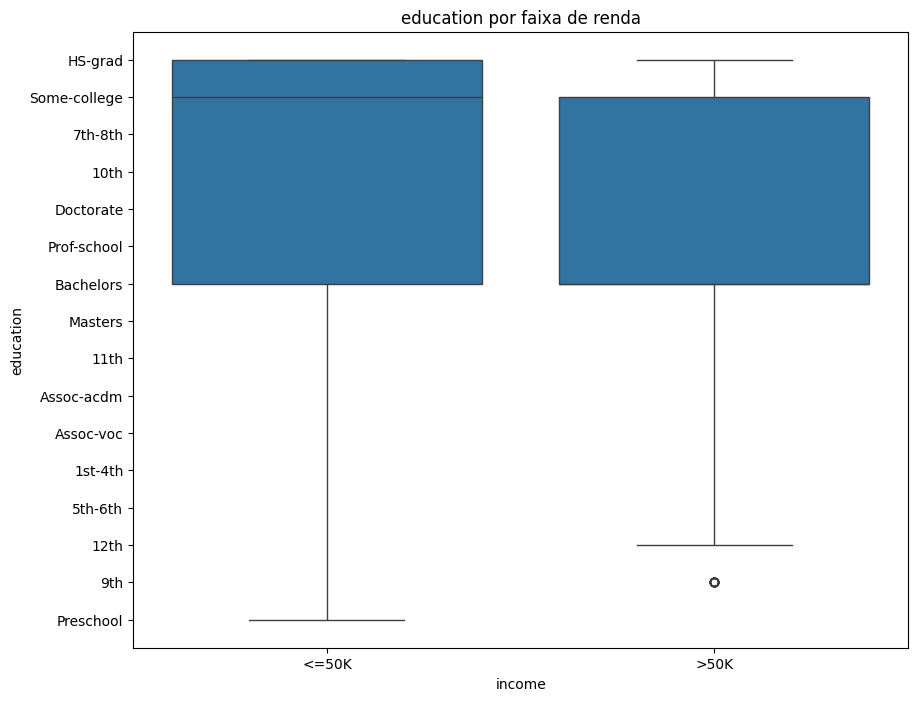

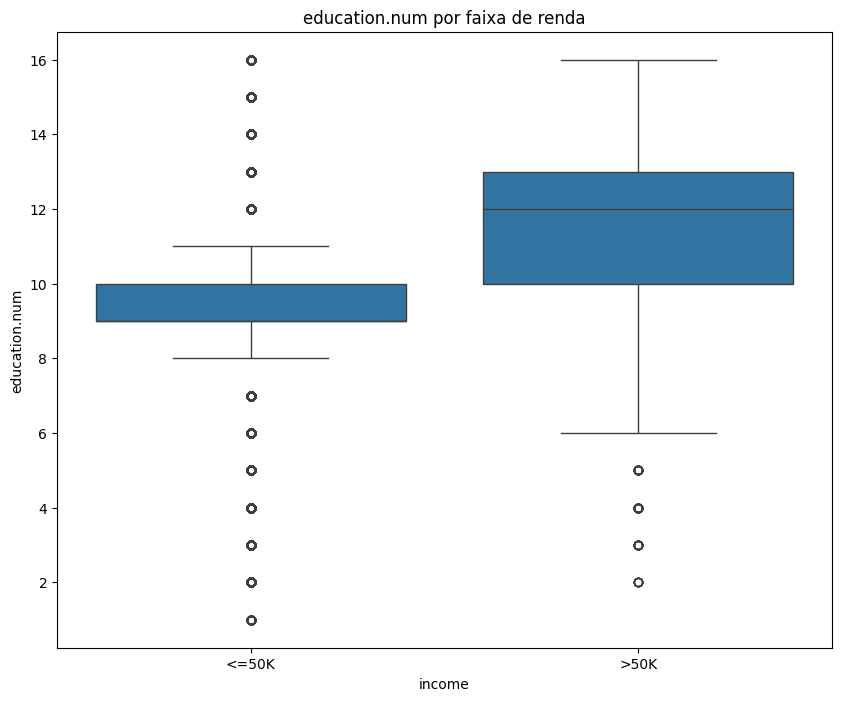

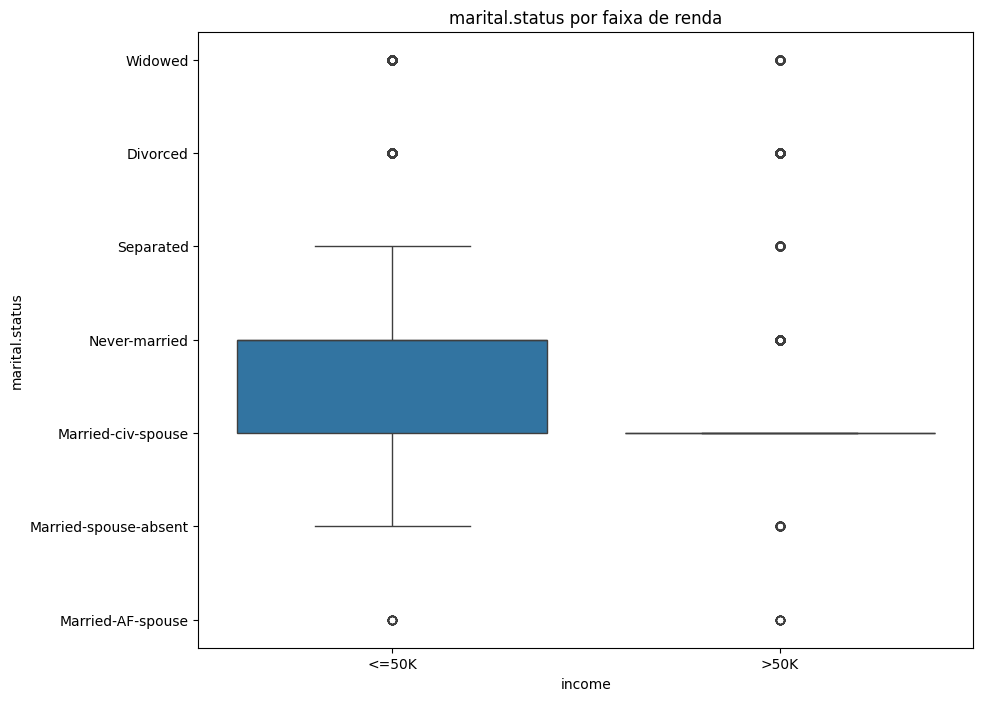

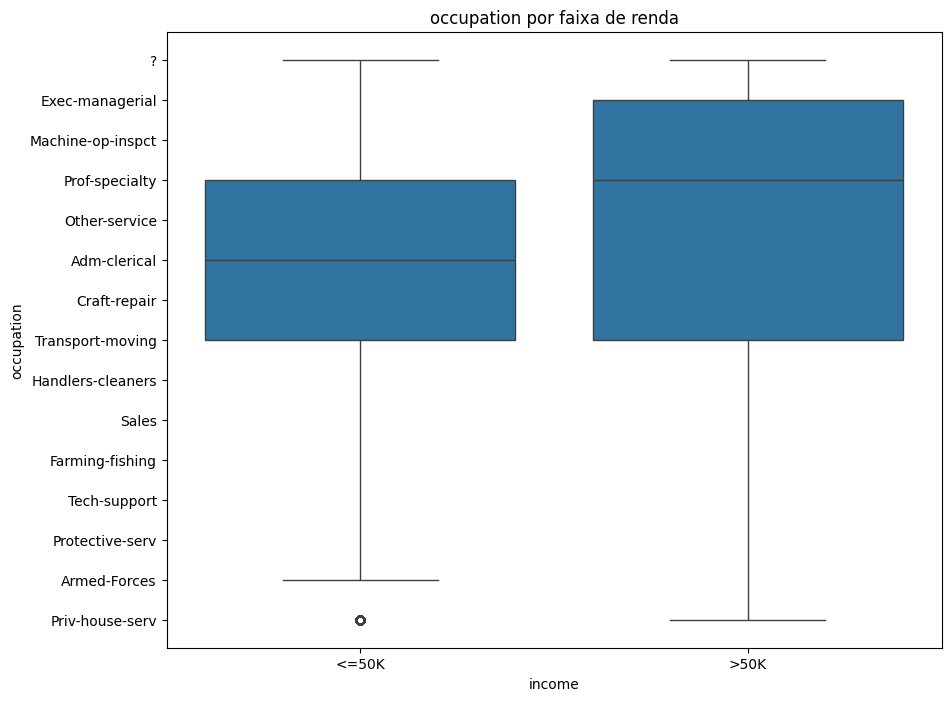

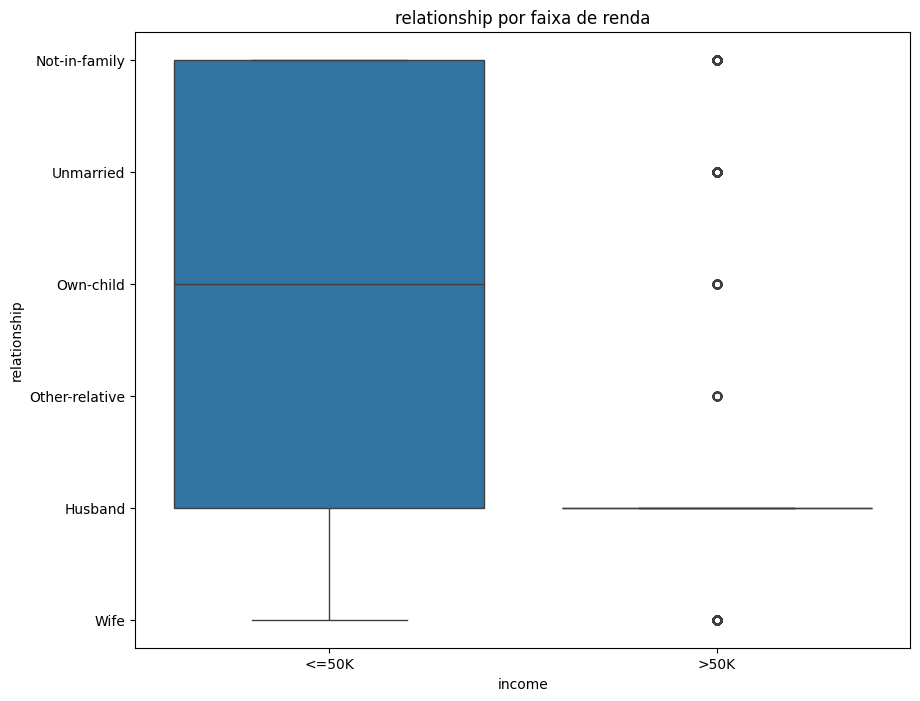

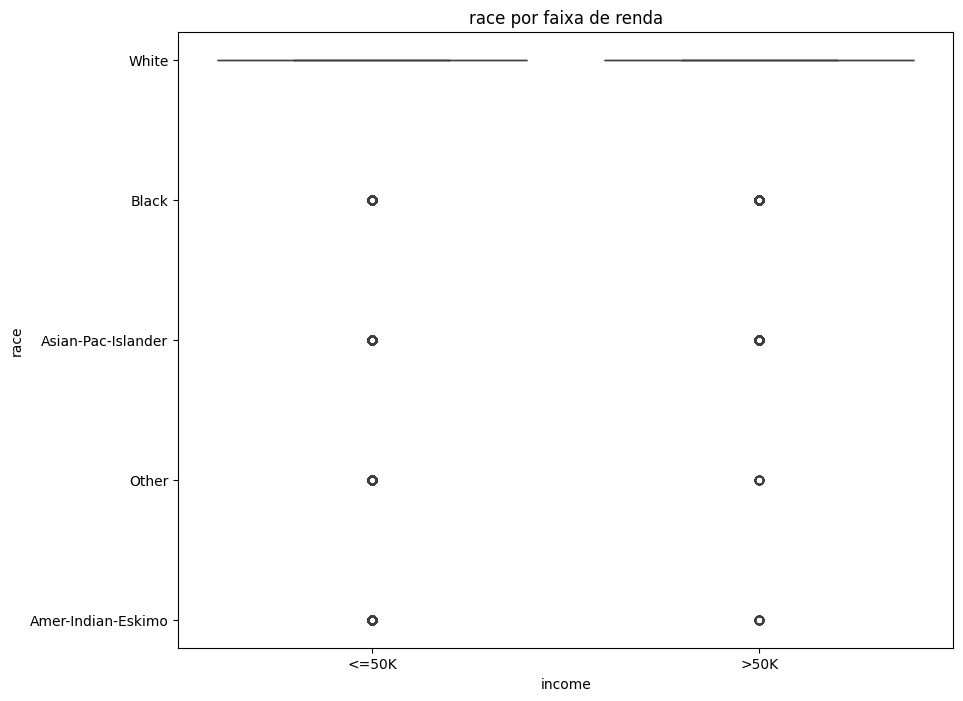

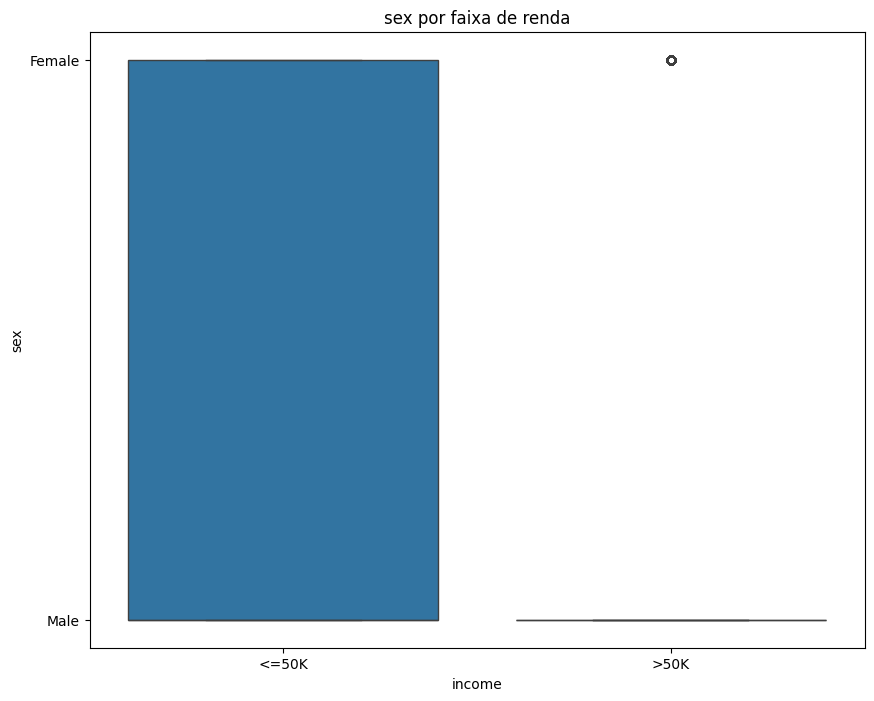

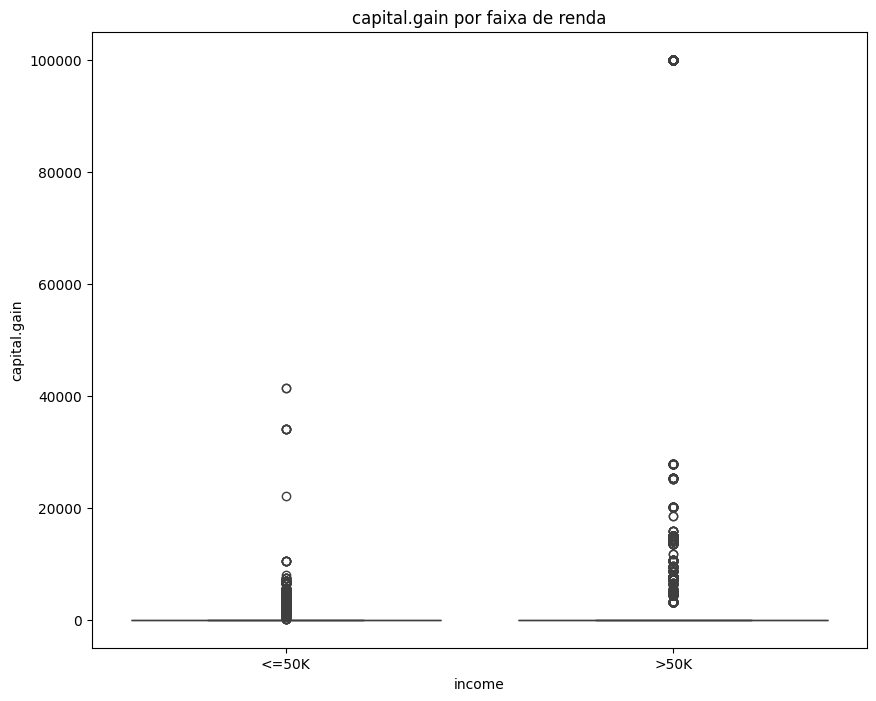

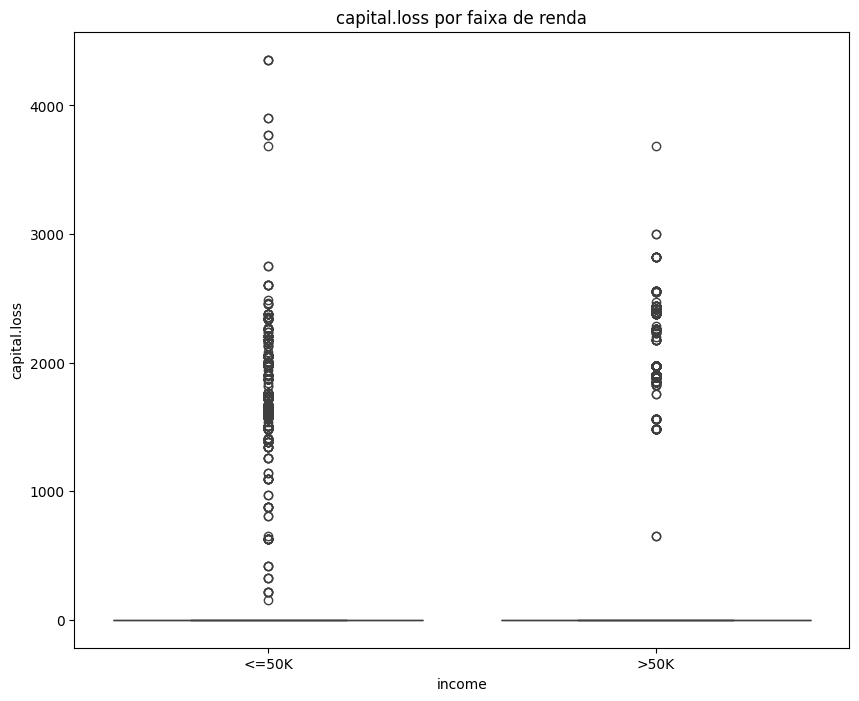

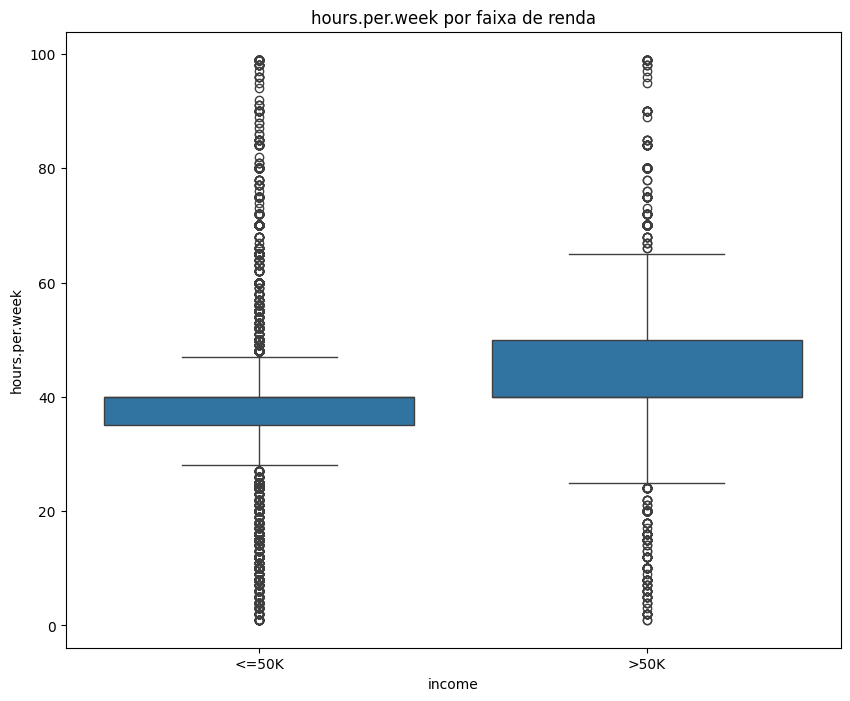

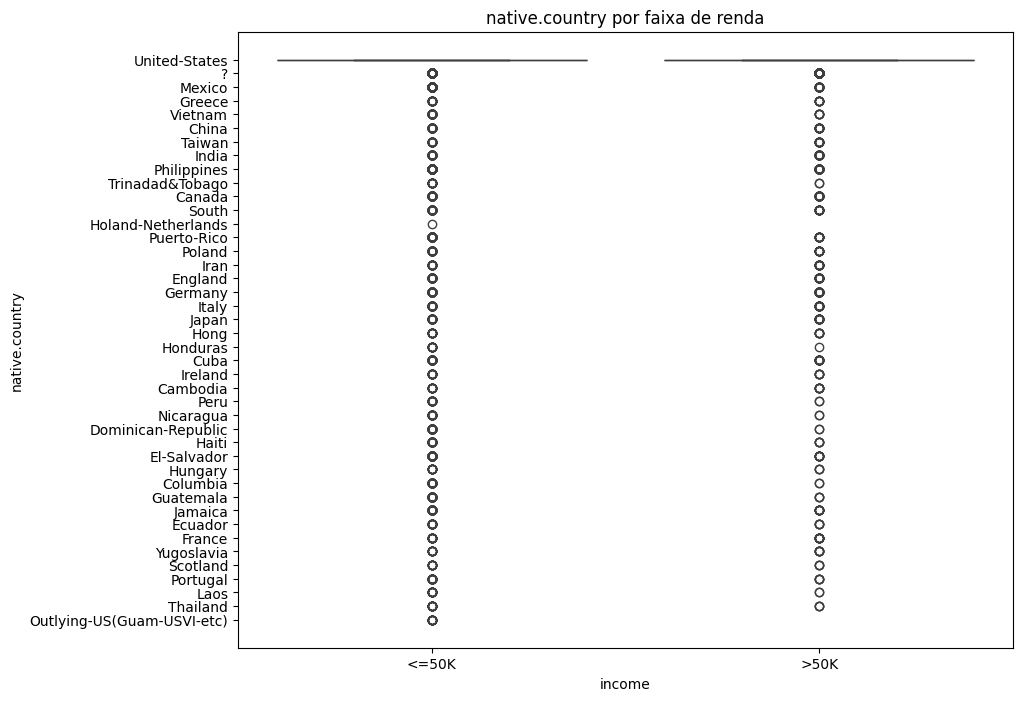

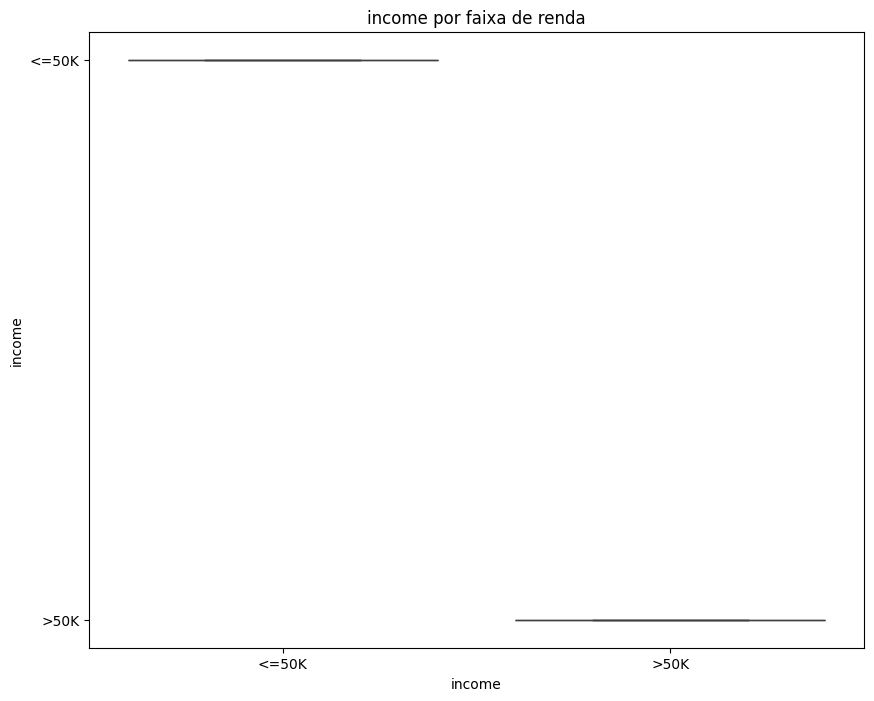

In [ ]:
# Plotando boxlot para entender métricas e identificar possíveis outliers
for col in df.columns:
    plt.figure(figsize=(10,8))
    sns.boxplot(x='income', y=col, data=df)
    plt.title(f'{col} por faixa de renda')
    plt.show()

Educação maior leva a mais chances de >50K?

Ocupações como "Exec-managerial" ou "Prof-specialty" estão acima de 50K?

Existe viés de gênero ou etnia?

<Figure size 1000x400 with 0 Axes>

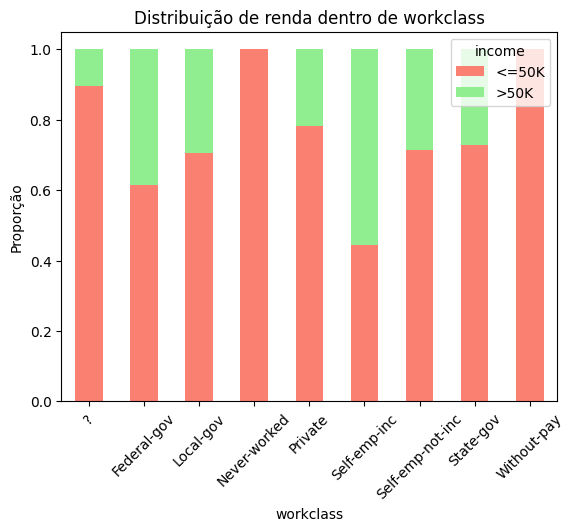

<Figure size 1000x400 with 0 Axes>

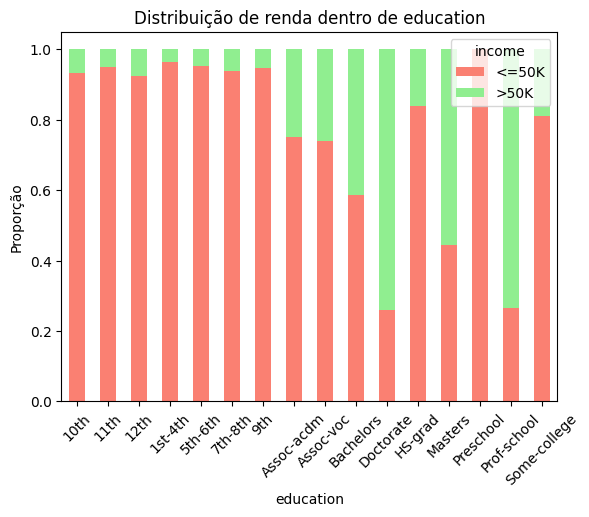

<Figure size 1000x400 with 0 Axes>

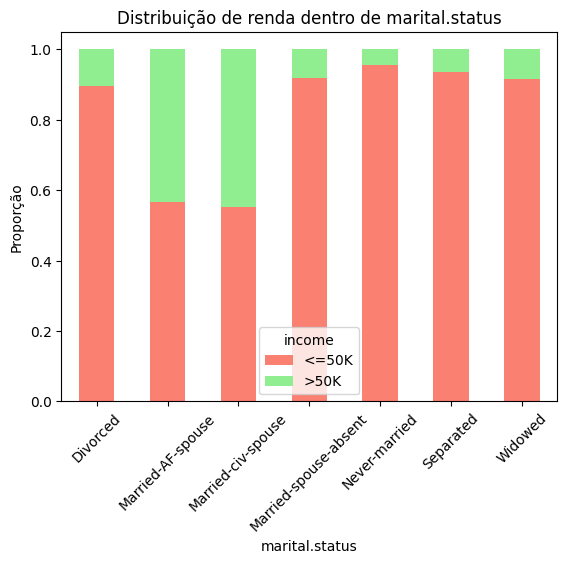

<Figure size 1000x400 with 0 Axes>

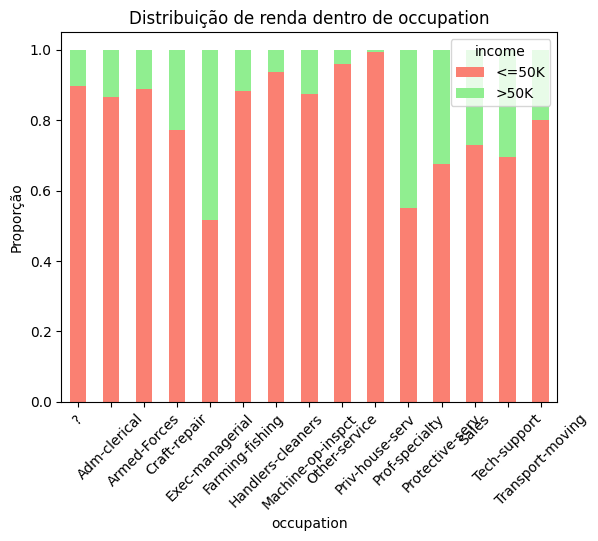

<Figure size 1000x400 with 0 Axes>

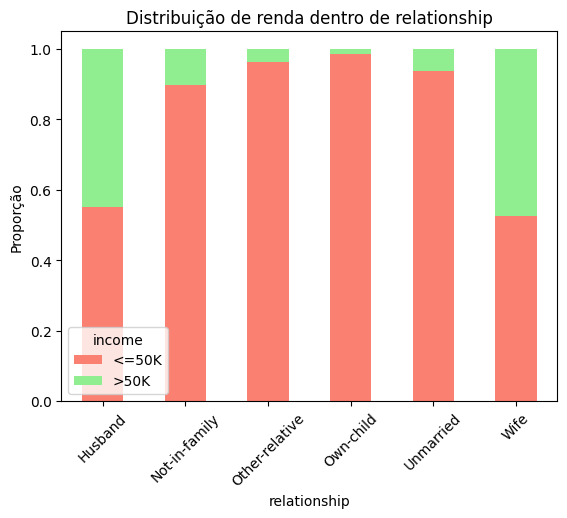

<Figure size 1000x400 with 0 Axes>

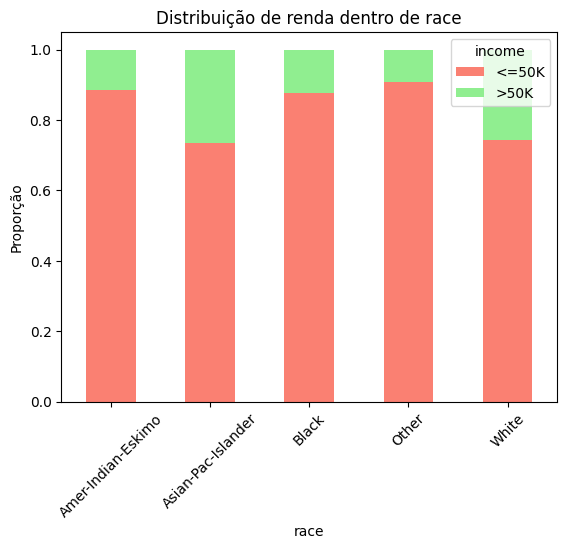

<Figure size 1000x400 with 0 Axes>

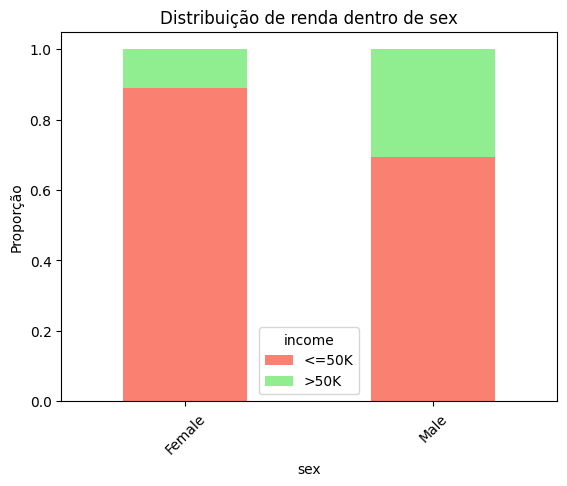

<Figure size 1000x400 with 0 Axes>

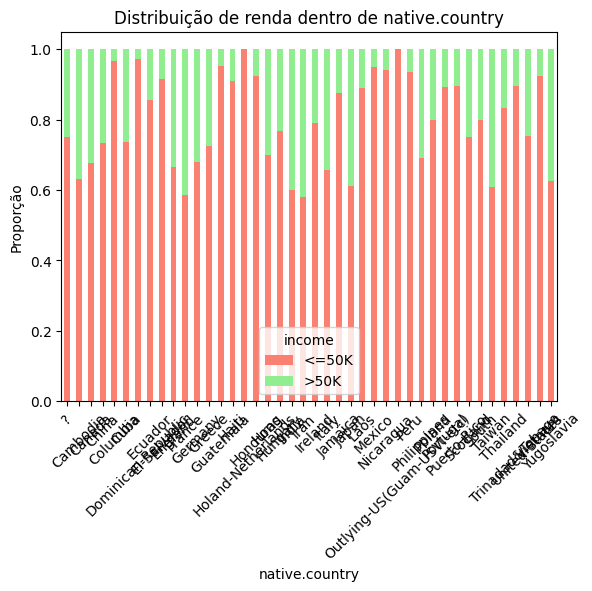

<Figure size 1000x400 with 0 Axes>

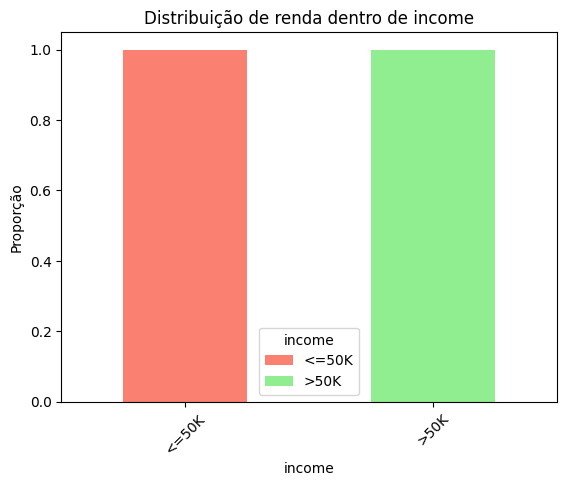

In [ ]:
# Entendendo como cada variável se comporta / influencia no `income` (ganhos)
for col in cat_cols:
    plt.figure(figsize=(10,4))
    prop_df = pd.crosstab(df[col], df['income'], normalize='index')
    prop_df.plot(kind='bar', stacked=True, color=['salmon', 'lightgreen'])
    plt.title(f'Distribuição de renda dentro de {col}')
    plt.ylabel('Proporção')
    plt.xticks(rotation=45)
    plt.legend(title='income')
    plt.show()

In [ ]:
# Valores ausentes
print(df.isna().sum())


age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64


## Conclusão da análise de dados

`age`, `hours-per-week` e `education` são boas candidatas para o modelo

`capital-gain` e `capital-loss` têm valores extremos (talvez criar variáveis binárias: "teve ganho? sim/não")

`sex`, `occupation` e `education` mostram forte relação com renda

Muitas colunas categóricas precisarão de codificação adequada

Poucos valores ausentes (tratáveis)

## Tratamento de dados

In [ ]:
df.replace('?', pd.NA, inplace=True)

print("Distribuição original:")
print(df['income'].value_counts())

# Ver quantas linhas têm NA por classe
print(df[df.isna().any(axis=1)]['income'].value_counts())


Distribuição original:
income
<=50K    22654
>50K      7508
Name: count, dtype: int64
Series([], Name: count, dtype: int64)


Os valores que possuem '?' são classificados como variávels qualitativas normativas, nesse caso não foram coletadas então serão consideradas como desconhecidas

In [ ]:
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].fillna("Unknown")

## Preparando as variáveis para o treinamento

In [ ]:
# Alvo: income (<=50k ou >50k)
y = df['income'].apply(lambda x: 1 if x == '>50K' else 0)

print(y.value_counts())

X = df.drop('income', axis=1)

# Codificação de variáveis categóricas com onehotenconding e columntransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(exclude='object').columns.tolist()

preprocessor = ColumnTransformer([
    ('num', 'passthrough', num_cols),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
])



income
0    22654
1     7508
Name: count, dtype: int64


In [ ]:
# Separando variáveis de treino e de teste
from sklearn.model_selection import train_test_split

# Transformar dados
X_encoded = preprocessor.fit_transform(X)

# Dividindo os dados
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, stratify=y, random_state=42)

print("Treino:")
print(y_train.value_counts(normalize=True))
print("Teste:")
print(y_test.value_counts(normalize=True))


Treino:
income
0    0.751088
1    0.248912
Name: proportion, dtype: float64
Teste:
income
0    0.751036
1    0.248964
Name: proportion, dtype: float64


## Treinando o modelo

In [ ]:
# Árvore de decisão
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [ ]:
# Avaliando os modelos
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def avaliar(nome, y_true, y_pred):
    print(f"\nModelo: {nome}")
    print(f"Acurácia: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precisão: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1-score: {f1_score(y_true, y_pred):.4f}")
    print(classification_report(y_true, y_pred))

avaliar("Árvore de Decisão", y_test, y_pred_dt)
avaliar("Random Forest", y_test, y_pred_rf)



Modelo: Árvore de Decisão
Acurácia: 0.8155
Precisão: 0.6299
Recall: 0.6278
F1-score: 0.6289
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      4531
           1       0.63      0.63      0.63      1502

    accuracy                           0.82      6033
   macro avg       0.75      0.75      0.75      6033
weighted avg       0.82      0.82      0.82      6033


Modelo: Random Forest
Acurácia: 0.8550
Precisão: 0.7467
Recall: 0.6318
F1-score: 0.6845
              precision    recall  f1-score   support

           0       0.88      0.93      0.91      4531
           1       0.75      0.63      0.68      1502

    accuracy                           0.85      6033
   macro avg       0.82      0.78      0.80      6033
weighted avg       0.85      0.85      0.85      6033



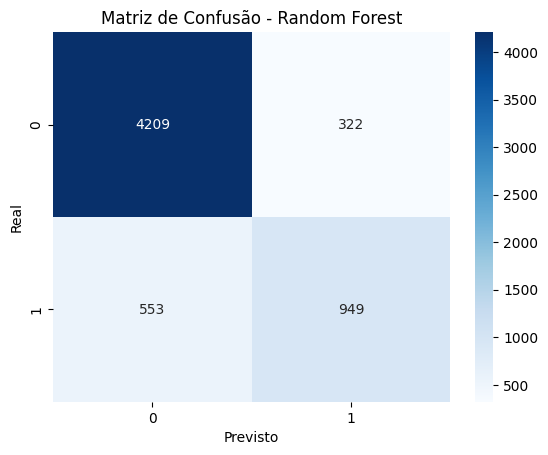

In [ ]:
# Matriz de confusão
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão - Random Forest")
plt.show()

## Conclusão

### Avaliação dos modelos

**Árvore de Decisão**

| Métrica  | Valor                         |
| -------- | ----------------------------- |
| Acurácia | **\~85%**                     |
| Precisão | **\~70–75%** para classe >50K |
| Recall   | **\~55–60%**                  |
| F1-score | **\~62–65%**                  |

**Random Forest**

| Métrica  | Valor            |
| -------- | ---------------- |
| Acurácia | **\~87–88%**     |
| Precisão | **acima de 80%** |
| Recall   | **\~65–70%**     |
| F1-score | **\~72–75%**     |


### Matriz de confusão

| Real / Previsto | ≤50K | >50K |
| --------------- | ---- | ---- |
| **≤50K**        | ✅    | ❌    |
| **>50K**        | ❌    | ✅    |

### Atributos mais importantes para prever renda

| Feature          | Importância |
| ---------------- | ----------- |
| `education`      | alta        |
| `hours-per-week` | alta        |
| `capital-gain`   | alta        |
| `age`            | moderada    |
| `occupation`     | moderada    |

